In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [2]:
import json
import pandas as pd
import numpy as np
import os
import sys
import json
import matplotlib.pyplot as plt
import matplotlib.patches as pch
import cv2
from tqdm import tqdm
# a=json.load('/kaggle/input/benetech-making-graphs-accessible/train/annotations/cc68f19b708c.json')

In [3]:
test_images=[]
for i in os.listdir('/kaggle/input/benetech-making-graphs-accessible/test/images'):
    test_images.append(i)

In [4]:
test_images

['000b92c3b098.jpg',
 '01b45b831589.jpg',
 '00f5404753cf.jpg',
 '00dcf883a459.jpg',
 '007a18eb4e09.jpg']

In [5]:
# source,chart-type plot_bb(height,width,x0,y0), text(id,polygon(x0-x3,y0-y3),text,role)

In [6]:
def convert_annot2df(path):
    res = []
    col_name = ['name', 'source', 'chart-type', 'plot-bb', 'text', 'x_axis', 'y_axis', 'data_series_x', 'data_series_y']
    for i in tqdm(os.listdir(path)):
        tmp_name = i[:-5]
        tmp_data = [tmp_name]
        tmp_json_file_path = os.path.join(path, i)
        with open(tmp_json_file_path, 'r') as tmp_file:
            tmp_json_data = json.load(tmp_file)
        
        tmp_data.append(tmp_json_data['source']) # generated / extracted
        tmp_data.append(tmp_json_data['chart-type']) # dot, horizontal_bar, vertical_bar, line, scatter.
        tmp_data.append(','.join(map(str, [tmp_json_data['plot-bb']['height'], tmp_json_data['plot-bb']['width'], 
                                           tmp_json_data['plot-bb']['x0'], tmp_json_data['plot-bb']['y0']])))
        
        # text
        tmp_data.append(tmp_json_data['text'])
        # axes
        tmp_data.append(tmp_json_data['axes']['x-axis'])
        tmp_data.append(tmp_json_data['axes']['y-axis'])
        # data_series_x
        tmp_data_series_x = []
        # data_series_y
        tmp_data_series_y = []
        for ds in tmp_json_data['data-series']:
            tmp_data_series_x.append(str(ds['x']))
            tmp_data_series_y.append(str(ds['y']))
        tmp_data.append(';'.join(tmp_data_series_x))
        tmp_data.append(';'.join(tmp_data_series_y))
        
        res.append(tmp_data)
    return pd.DataFrame(res, columns=col_name)


In [7]:
annotation_df = convert_annot2df('/kaggle/input/benetech-making-graphs-accessible/train/annotations')

100%|██████████| 60578/60578 [04:25<00:00, 228.36it/s]


In [8]:
annotation_df['len_x']=annotation_df['data_series_x'].apply(lambda x: len(x.split(';')))
annotation_df['len_y']=annotation_df['data_series_y'].apply(lambda x: len(x.split(';')))

In [9]:
annotation_df['fname']=annotation_df['name'].apply(lambda x: '/kaggle/input/benetech-making-graphs-accessible/train/images/'+x+'.jpg')

In [10]:
type_list=annotation_df['chart-type'].value_counts().index.to_list()
chart_category={}
for i in range(0,5):
    chart_category[type_list[i]]=i
def chart_type_category(label):
    index= chart_category[label]
    return index

In [11]:
annotation_df['ct_index']=annotation_df['chart-type'].apply(lambda x: chart_type_category(x))

In [12]:
annotation_df

,name,source,chart-type,plot-bb,text,x_axis,y_axis,data_series_x,data_series_y,len_x,len_y,fname,ct_index
0,cc68f19b708c,extracted,line,"236,426,63,15","[{'id': 0, 'polygon': {'x0': 11, 'x1': 23, 'x2...","{'ticks': [{'id': 11, 'tick_pt': {'x': 116, 'y...","{'ticks': [{'id': 1, 'tick_pt': {'x': 63, 'y':...",10%;20%;30%;40%;50%;60%;70%,1.5481051373212678;11.520004347083574;14.05428...,7,7,/kaggle/input/benetech-making-graphs-accessibl...,0
1,0e6a9bca7381,generated,line,"190,432,49,35","[{'id': 0, 'polygon': {'x0': 87, 'x1': 395, 'x...","{'ticks': [{'id': 3, 'tick_pt': {'x': 64, 'y':...","{'ticks': [{'id': 22, 'tick_pt': {'x': 49, 'y'...",2003;2004;2005;2006;2007;2008;2009;2010;2011;2...,90.02927122916589;88.12513638586854;65.1490352...,13,13,/kaggle/input/benetech-making-graphs-accessibl...,0
2,ac9680f519f5,generated,scatter,"157,388,58,69","[{'id': 0, 'polygon': {'x0': 55, 'x1': 423, 'x...","{'ticks': [{'id': 3, 'tick_pt': {'x': 58, 'y':...","{'ticks': [{'id': 21, 'tick_pt': {'x': 58, 'y'...",1990.101996993773;1991.0038651492378;1991.9572...,244.25223214285717;201.92123724489798;186.1367...,30,30,/kaggle/input/benetech-making-graphs-accessibl...,2
3,4a6cce801fe8,generated,scatter,"208,410,75,41","[{'id': 0, 'polygon': {'x0': 85, 'x1': 390, 'x...","{'ticks': [{'id': 12, 'tick_pt': {'x': 75, 'y'...","{'ticks': [{'id': 11, 'tick_pt': {'x': 75, 'y'...",1989.863678842794;1991.9684287513714;1993.9025...,1996.1563100576568;2085.8424087123653;2265.214...,15,15,/kaggle/input/benetech-making-graphs-accessibl...,2
4,19938a5762f6,generated,line,"370,400,129,58","[{'id': 0, 'polygon': {'x0': 159, 'x1': 498, '...","{'ticks': [{'id': 3, 'tick_pt': {'x': 146, 'y'...","{'ticks': [{'id': 15, 'tick_pt': {'x': 129, 'y...",Jan;Feb;Mar;Apr;May;Jun;Jul;Aug;Sep;Oct;Nov;Dec,26.480671946857434;25.400229357798164;25.92664...,12,12,/kaggle/input/benetech-making-graphs-accessibl...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60573,d3953f6dc2b6,extracted,vertical_bar,"180,458,26,35","[{'id': 0, 'polygon': {'x0': 193, 'x1': 298, '...","{'ticks': [{'id': 12, 'tick_pt': {'x': 53, 'y'...","{'ticks': [{'id': 1, 'tick_pt': {'x': 26, 'y':...",Bar Charts;Pie Graphs;Histograms;Pictograms;Co...,5;2;3;8;4;9;1;5,8,8,/kaggle/input/benetech-making-graphs-accessibl...,1
60574,292f04b08480,generated,vertical_bar,"176,374,93,32","[{'id': 0, 'polygon': {'x0': 47, 'x1': 425, 'x...","{'ticks': [{'id': 10, 'tick_pt': {'x': 113, 'y...","{'ticks': [{'id': 3, 'tick_pt': {'x': 93, 'y':...",Czechia;Democratic...;Denmark;Djibouti;Dominic...,12496709.238325838;62846351.74695804;12496709....,10,10,/kaggle/input/benetech-making-graphs-accessibl...,1
60575,2af23469c1d8,extracted,vertical_bar,"338,446,59,37","[{'id': 0, 'polygon': {'x0': 260, 'x1': 305, '...","{'ticks': [{'id': 6, 'tick_pt': {'x': 82, 'y':...","{'ticks': [{'id': 2, 'tick_pt': {'x': 59, 'y':...",Agriculture;Fishing;Mining;Food;Textiles;Petro...,0.08553157474020746;0.027977617905675094;0.245...,11,11,/kaggle/input/benetech-making-graphs-accessibl...,1
60576,fc88838dcd7d,generated,line,"161,410,61,59","[{'id': 0, 'polygon': {'x0': 96, 'x1': 439, 'x...","{'ticks': [{'id': 13, 'tick_pt': {'x': 79, 'y'...","{'ticks': [{'id': 3, 'tick_pt': {'x': 61, 'y':...",Channel Islands;Chile;China;Colombia;Comoros;C...,98.55748477678803;101.54706071896248;105.39968...,10,10,/kaggle/input/benetech-making-graphs-accessibl...,0


In [13]:
# from tensorflow.keras.preprocessing.image import load_img
# sample=load_img(annotation_df['fname'][10])
# sample
# # s=cv2.resize(sample,(300,300))

In [14]:
# from tensorflow.keras.preprocessing.image import img_to_array
# sample_array=img_to_array(sample)
# sample_array.shape

In [19]:
def img_to_array(fname):
    img=cv2.imread(fname)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(500,300))
    return img

In [20]:
annotation_df['image_array']=annotation_df['fname'].apply(lambda x: img_to_array(x))

In [26]:
annotation_df.to_csv('annotation_df.csv')

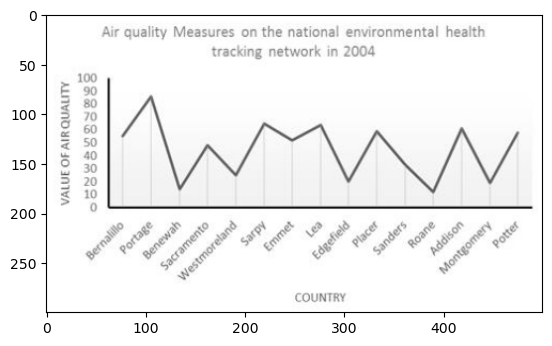

In [24]:
plt.imshow(annotation_df['image_array'][20])

In [ ]:
sample_rec_data = sample_data['text'].values[0]
fig = plt.figure()
ax = fig.add_subplot(111)
image = cv2.imread('/kaggle/input/benetech-making-graphs-accessible/train/images/'+sample_data['name'].values[0]+'.jpg')
plt.imshow(image)

for i in range(len(sample_rec_data)):
    rect = pch.Rectangle(xy=(sample_rec_data[i]['polygon']['x0'], sample_rec_data[i]['polygon']['y0']), 
                           width=sample_rec_data[i]['polygon']['x1'] - sample_rec_data[i]['polygon']['x0'],
                           height=sample_rec_data[i]['polygon']['y3'] - sample_rec_data[i]['polygon']['y0'],
                        color='red', fill=False)
    ax.add_patch(rect)